In [3]:
from learn import em_learn, svd_learn_new
from data import *
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def svd_learn(sample, n, L=None, verbose=None, stats={}):
    Os = np.moveaxis(sample.all_trail_probs(), 1, 0)

    svds = [np.linalg.svd(Os[j], full_matrices=True) for j in range(n)]

    if verbose:
        for i, (_, s, _) in enumerate(svds):
            print(f"{i}: {s[:L+1]} ...")

    Ps_ = np.zeros((n, L, n))
    Qs_ = np.zeros((n, L, n))
    for j, (u, s, vh) in enumerate(svds):
        Ps_[j, 0 : min(n, L), :] = u[:, 0:L].T
        Qs_[j, 0 : min(n, L), :] = (np.diag(s) @ (vh))[0:L, :]

    A = np.zeros((2 * n * L, n**2))
    for j in range(n):
        A[L * j : L * (j + 1), n * j : n * (j + 1)] = Ps_[j]
        A[L * (n + j) : L * (n + j + 1), j + n * (np.arange(n))] = -Qs_[j]

    _, s, vh = np.linalg.svd(A.T, full_matrices=True)
    small = list(s < 1e-5)
    if True in small:
        fst = small.index(True)
        if verbose:
            print(2 * L * n - fst, L, s[[fst - 1, fst]])
    B = vh[-L:]
    Bre = np.moveaxis(B.reshape((L, L, 2 * n), order="F"), -1, 0)
    Ys_ = Bre[0:n]
    Zs_ = Bre[n : 2 * n]

    Xs = [
        np.linalg.pinv(Zs_[j] @ Ys_[j].T) @ (Zs_[j + 1] @ Ys_[j + 1].T)
        for j in range(n - 1)
    ]
    X = np.sum(Xs, axis=0)
    _, R_ = np.linalg.eig(X)
    d, _, _, _ = np.linalg.lstsq(
        (R_.T @ Ys_[0] @ Ps_[0]).T, Os[0] @ np.ones(n), rcond=None
    )

    R = np.diag(d) @ R_.T
    Ys = R @ Ys_
    Ps = np.array([Y @ P_ for Y, P_ in zip(Ys, Ps_)])
    Ss = np.array([R @ Z_ @ Y_.T @ R.T for Z_, Y_ in zip(Zs_, Ys_)])

    S_ = np.zeros((L, n))
    Ms_ = np.zeros((L, n, n))
    for l in range(L):
        for i in range(n):
            S_[l, i] = Ss[i, l, l]
            for j in range(n):
                Ms_[l, i, j] = Ps[j, l, i] / S_[l, i]

    S_ = np.abs(S_)
    Ms_ = np.abs(Ms_)
    learned_mixture = Mixture(S_, Ms_)
    learned_mixture.normalize()
    return learned_mixture

learners = {
    "CA-SVD": svd_learn_new,
    "CA-SVD'": lambda d, n, L: svd_learn_new(d, n, L, sample_dist=0.01),
    "GKV-SVD": svd_learn,
    "EM2": lambda d, n, L: em_learn(d, n, L, max_iter=2),
    "EM5": lambda d, n, L: em_learn(d, n, L, max_iter=5),
    "EM20": lambda d, n, L: em_learn(d, n, L, max_iter=20),
    "EM50": lambda d, n, L: em_learn(d, n, L, max_iter=50),
    "EM100": lambda d, n, L: em_learn(d, n, L, max_iter=100),
    "EM-converge": em_learn,
    "CA-SVD-EM2": lambda d, n, L: svd_learn_new(d, n, L, em_refine_max_iter=2),
    "CA-SVD-EM5": lambda d, n, L: svd_learn_new(d, n, L, em_refine_max_iter=5),
    "CA-SVD-EM20": lambda d, n, L: svd_learn_new(d, n, L, em_refine_max_iter=20),
    "CA-SVD-EM100": lambda d, n, L: svd_learn_new(d, n, L, em_refine_max_iter=100),
}

def count_3_from_seq(seq, n):
    """
    seq: discretized sequence
    n: number of categories
    """
    all_trail_probs = np.zeros((n, n, n)) 
    for i in range(len(seq) // 3):
        x = seq[3*i:3*(i+1)]
        all_trail_probs[tuple(x)] += 1
       #num_visited[x] += 1
    return Distribution.from_all_trail_probs(all_trail_probs / np.sum(all_trail_probs))
    
def learn_mix_from_seq(seq,learner, n, L):
    """
    seq: discretized time series: an 1-d array
    learner: 
    """
    trail_empirical_distribution = count_3_from_seq(seq, n)
    if np.isnan(trail_empirical_distribution.all_trail_probs()).any() or np.isinf(trail_empirical_distribution.all_trail_probs()).any():
        print("Inf or NAN values")
        print(trail_empirical_distribution.all_trail_probs())
        
    return  learners[learner](trail_empirical_distribution, n, L)

def likelihood(mixture, trails, counts=None, log=False):
    if counts is None: counts = transitions(mixture.n, trails)
    logS = np.log(mixture.S + 1e-10)
    logTs = np.log(mixture.Ms + 1e-10)

    logl = logS[:, trails[:,0]]
    logl += np.sum(logTs[:, :, :, None] * np.moveaxis(counts, 0, 2)[None, :, :, :], axis=(1,2))
    if log: return logl
    probs = np.exp(logl - np.max(logl, axis=0))
    probs /= np.sum(probs, axis=0)[None, :]
    return probs

def transitions(n, trails):
    n_samples = trails.shape[0]
    c = np.zeros([n_samples, n, n], dtype=int)
    for t, trail in enumerate(trails):
        i = trail[0]
        for j in trail[1:]:
            c[t, i, j] += 1
            i = j
    return c

In [5]:
n_states = [10,20]
L_chains = [2,3,4,5,6,7]

mix_err = np.zeros((len(n_states), len(L_chains)))
for i in range(len(n_states)):
    for j in range(len(L_chains)):
        mix = Mixture.random(n_states[i], L_chains[j])
        ground_truth_distribution = Distribution.from_mixture(mix, t_len=3)
        sample_distribution = ground_truth_distribution.sample(n_samples = int(1e8))
        learned_mixture = learners["GKV-SVD"](sample_distribution, n_states[i], L = L_chains[j])
        mix_err[i,j] = learned_mixture.recovery_error(mix)



/var/folders/kx/06y42x8s5571j9jqkpc5wf500000gn/T/ipykernel_69524/2861410156.py:51: ComplexWarning: Casting complex values to real discards the imaginary part
  S_[l, i] = Ss[i, l, l]
/var/folders/kx/06y42x8s5571j9jqkpc5wf500000gn/T/ipykernel_69524/2861410156.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  Ms_[l, i, j] = Ps[j, l, i] / S_[l, i]


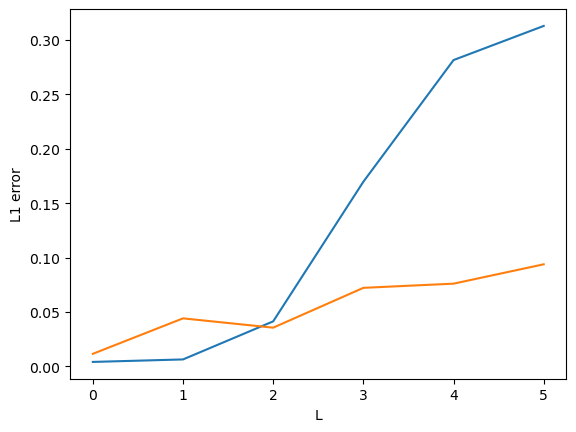

In [6]:
mix_err

plt.xlabel("L")
plt.ylabel("L1 error")
plt.plot(mix_err[0,:])
plt.plot(mix_err[1,:])


In [7]:
learned_distribution = Distribution.from_mixture(learned_mixture, 3)
learned_distribution.dist(ground_truth_distribution)

0.0918521609744558

In [8]:
learned_mixture.recovery_error(mix)

0.09378450197396078